In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, hamming_loss, accuracy_score, precision_score, recall_score
from tqdm import tqdm

# ─────────────────────────────────────────────────────
def load_and_clean_data(filepath, text_column='CleanBodyNoMath', tag_column='Tags'):
    df = pd.read_csv(filepath)

    def split_pipes(x):
        if isinstance(x, list):
            return x
        if pd.isna(x):
            return []
        return [p for p in x.strip("|").split("|") if p]

    df[tag_column] = df[tag_column].apply(split_pipes)
    df = df[df[tag_column].map(len) > 0].reset_index(drop=True)
    return df[[text_column, tag_column]]

# ─────────────────────────────────────────────────────
#here!!! 'all-MiniLM-L6-v2'
def embed_texts(texts, model_name='all-MiniLM-L6-v2', batch_size=64, device='cuda'):
    model = SentenceTransformer(model_name, device=device)
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True, convert_to_numpy=True)
    return embeddings, model

# ─────────────────────────────────────────────────────
def train_classifiers(X_train, y_train):
    classifiers = []
    valid_tag_indices = []

    for i in tqdm(range(y_train.shape[1]), desc="Training Tags", unit="tag"):
        y_tag = y_train[:, i]
        if np.unique(y_tag).size < 2:
            classifiers.append(None)
            continue
        #here!!
        clf = LogisticRegression(max_iter=500)
        clf.fit(X_train, y_tag)
        classifiers.append(clf)
        valid_tag_indices.append(i)

    return classifiers, valid_tag_indices

# ─────────────────────────────────────────────────────
def evaluate_top_k(X_eval, y_eval, classifiers, valid_tag_indices, mlb_valid, df, idx_eval, k=3):
    probas = []
    for idx in valid_tag_indices:
        clf = classifiers[idx]
        if clf is not None:
            probas.append(clf.predict_proba(X_eval)[:, 1])
        else:
            probas.append(np.zeros(X_eval.shape[0]))
    probas = np.vstack(probas).T

    top_k_pred = []
    for row in probas:
        top_indices = row.argsort()[-k:][::-1]
        binary = np.zeros_like(row)
        binary[top_indices] = 1
        top_k_pred.append(binary)
    y_pred_topk = np.array(top_k_pred)
    y_eval_valid = y_eval[:, valid_tag_indices]

    f1 = f1_score(y_eval_valid, y_pred_topk, average='micro')
    f1_weighted_macro = f1_score(y_eval_valid, y_pred_topk, average='weighted')

    h_loss = hamming_loss(y_eval_valid, y_pred_topk)
    acc = accuracy_score(y_eval_valid, y_pred_topk)
    precision = precision_score(y_eval_valid, y_pred_topk, average='micro', zero_division=0)
    recall = recall_score(y_eval_valid, y_pred_topk, average='micro', zero_division=0)


    true_tag_sets = [set(df.iloc[i]['Tags']) for i in idx_eval]
    pred_tag_sets = []
    for row in y_pred_topk:
        tag_indices = np.where(row == 1)[0]
        tags = set([mlb_valid.classes_[j] for j in tag_indices])
        pred_tag_sets.append(tags)

    completely_wrong = [
        len(true_tags & pred_tags) == 0
        for true_tags, pred_tags in zip(true_tag_sets, pred_tag_sets)
    ]

    miss_rate = sum(completely_wrong) / len(completely_wrong)
    hit_rate = 1 - miss_rate

    return {
        'metrics': {
            'f1': f1,
            'f1_weighted_macro': f1_weighted_macro,
            'hamming_loss': h_loss,
            'subset_accuracy': acc,
            'miss_rate': miss_rate,
            'hit_rate': hit_rate,
            'precision': precision,
            'recall': recall,
        },
        'y_eval_valid': y_eval_valid,
        'y_pred_topk': y_pred_topk,
        'mlb_valid': mlb_valid
    }

# ─────────────────────────────────────────────────────
def print_sample_predictions(X_eval, y_eval, classifiers, valid_tag_indices, mlb_valid, df, idx_eval, k=3, num_examples=5):
    probas = []
    for idx in valid_tag_indices:
        clf = classifiers[idx]
        if clf is not None:
            probas.append(clf.predict_proba(X_eval)[:, 1])
        else:
            probas.append(np.zeros(X_eval.shape[0]))
    probas = np.vstack(probas).T

    top_k_pred = []
    for row in probas:
        top_indices = row.argsort()[-k:][::-1]
        binary = np.zeros_like(row)
        binary[top_indices] = 1
        top_k_pred.append(binary)
    y_pred_topk = np.array(top_k_pred)

    true_tag_sets = [set(df.iloc[i]['Tags']) for i in idx_eval]
    pred_tag_sets = []
    for row in y_pred_topk:
        tag_indices = np.where(row == 1)[0]
        tags = set([mlb_valid.classes_[j] for j in tag_indices])
        pred_tag_sets.append(tags)

    examples = []
    for i, (true_tags, pred_tags) in enumerate(zip(true_tag_sets, pred_tag_sets)):
        overlap = true_tags & pred_tags
        correct = len(overlap) > 0
        examples.append({
            'correct': correct,
            'text': df.iloc[idx_eval[i]]['CleanBodyNoMath'],
            'true_tags': true_tags,
            'pred_tags': pred_tags
        })

    correct_preds = [ex for ex in examples if ex['correct']][:num_examples]
    wrong_preds = [ex for ex in examples if not ex['correct']][:num_examples]

    print("\n✅ Examples with at least one correct tag:\n")
    for ex in correct_preds:
        print("Post:", ex['text'][:300].replace("\n", " "), "...")
        print("True Tags:", ex['true_tags'])
        print("Predicted Tags:", ex['pred_tags'])
        print("✔️ Correct Match(s):", ex['true_tags'] & ex['pred_tags'])
        print("-" * 80)

    print("\n❌ Examples with no correct tags:\n")
    for ex in wrong_preds:
        print("Post:", ex['text'][:300].replace("\n", " "), "...")
        print("True Tags:", ex['true_tags'])
        print("Predicted Tags:", ex['pred_tags'])
        print("✖️  No Overlap")
        print("-" * 80)

# ─────────────────────────────────────────────────────
def run_pipeline(csv_path=None, df=None, sample_size=5000, k=3, seed=None, show_text = False):
    print("📦 Loading and cleaning data...")
    if df is None:
        if csv_path is None:
            raise ValueError("Either 'csv_path' or 'df' must be provided.")
        print("📦 Loading and cleaning data...")
        df = load_and_clean_data(csv_path)
    else:
        print("📦 Using pre-loaded DataFrame...")

    df = df.sample(sample_size, random_state=seed).reset_index(drop=True)

    print("🧠 Embedding texts...")
    texts = df['CleanBodyNoMath'].fillna('').tolist()
    X, model = embed_texts(texts)

    print("🔢 Binarizing tags...")
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(df['Tags'])

    print("✂️ Splitting data...")
    indices = np.arange(len(df))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, indices, test_size=0.2, random_state=42
    )

    assert not np.array_equal(X_train, X_test), "Train and test data are the same!"

    print("🔧 Training classifiers...")
    classifiers, valid_tag_indices = train_classifiers(X_train, y_train)
    valid_classes = [mlb.classes_[i] for i in valid_tag_indices]
    mlb_valid = MultiLabelBinarizer(classes=valid_classes)
    mlb_valid.fit([valid_classes])

    print("📊 Evaluating...")
    eval_output = evaluate_top_k(X_test, y_test, classifiers, valid_tag_indices, mlb_valid, df, idx_test, k=k)
    metrics = eval_output['metrics']
    y_eval_valid = eval_output['y_eval_valid']
    y_pred_topk = eval_output['y_pred_topk']
    mlb_valid = eval_output['mlb_valid']

    print(f"\n✅ Top-{k} Tag Evaluation:")
    for key, value in metrics.items():
        print(f"{key.replace('_', ' ').title()}: {value:.3f}")
    print(f"❌ Completely Wrong Predictions: {int(metrics['miss_rate'] * len(X_test))} out of {len(X_test)}")
    print(f"📉 Accuracy (at least 1 tag correct): {metrics['hit_rate']:.3f}")
    print(f"⚠️  Failure Rate (no tags correct):   {metrics['miss_rate']:.3f}")
    if show_text:
      print_sample_predictions(X_test, y_test, classifiers, valid_tag_indices, mlb_valid, df, idx_test, k=k, num_examples=5)

    return {
        'df': df,
        'model': model,
        'classifiers': classifiers,
        'valid_tag_indices': valid_tag_indices,
        'mlb': mlb,
        'mlb_valid': mlb_valid,
        'metrics': metrics,
        'y_eval_valid': y_eval_valid,
        'y_pred_topk': y_pred_topk,
        'idx_eval': idx_test,
        'X_eval': X_test,
        'valid_tag_indices': valid_tag_indices,
    }


C:\Users\jiali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utilis

In [3]:
def tag_wise_accuracy(y_true, y_pred, mlb_valid, top_n=10, min_support=50):
    results = []

    for i in range(y_true.shape[1]):
        true = y_true[:, i]
        pred = y_pred[:, i]
        total = true.sum()
        if total < min_support:
            continue
        correct = ((true == 1) & (pred == 1)).sum()
        acc = correct / total
        results.append((mlb_valid.classes_[i], acc, int(total)))

    results_sorted = sorted(results, key=lambda x: (x[1], x[2]), reverse=True)
    top_tags = results_sorted[:top_n]

    bottom_tags = sorted(results, key=lambda x: (x[1], x[2]))[:top_n]


    return top_tags, bottom_tags


In [4]:
def show_tag_examples(tag_name, y_eval_valid, y_pred_topk, mlb_valid, df, idx_eval, num_examples=5):
    if tag_name not in mlb_valid.classes_:
        print(f"❌ Tag '{tag_name}' not in valid tag set.")
        return

    tag_idx = list(mlb_valid.classes_).index(tag_name)
    matches = []

    for i, idx in enumerate(idx_eval):
        true = y_eval_valid[i, tag_idx]
        pred = y_pred_topk[i, tag_idx]
        if true == 1:
            matches.append((idx, pred, i))  # i is the index into y_eval_valid/y_pred_topk

    print(f"\n🕳️ Posts with tag: '{tag_name}' (max {num_examples})")
    print("-" * 80)

    shown = 0
    for idx, pred, i in matches:
        if shown >= num_examples:
            break
        print("✅ Correctly Predicted" if pred == 1 else "❌ Missed by Model")
        print(f"Post ID: {idx}")
        print("Post text:\n", df.iloc[idx]['CleanBodyNoMath'][:600].replace("\n", " "), "...")
        print("True Tags:", df.iloc[idx]['Tags'])

        # Show predicted tags for the post
        pred_row = y_pred_topk[i]
        pred_tag_indices = np.where(pred_row == 1)[0]
        pred_tags = [mlb_valid.classes_[j] for j in pred_tag_indices]
        print("Predicted Tags:", pred_tags)

        # Show intersection (correct predictions)
        correct_tags = set(pred_tags) & set(df.iloc[idx]['Tags'])
        if correct_tags:
            print("✔️ Correct Match(s):", correct_tags)
        else:
            print("✖️ No Correct Tags")
        print("-" * 80)
        shown += 1


In [5]:
def evaluate_multiple_seeds(df, sample_size=5000, k=5, seeds=[42], show_text=False):
    all_metrics = []

    # To store last model's predictions for inspection
    last_result = {}

    for s in seeds:
        result = run_pipeline(
            df=df,
            sample_size=sample_size,
            k=k,
            seed=s,
            show_text = show_text
        )
        all_metrics.append(result["metrics"])

        # Store last result for tag inspection later
        last_result = {
            'df': result['df'],
            'y_eval_valid': result['y_eval_valid'],
            'y_pred_topk': result['y_pred_topk'],
            'mlb_valid': result['mlb_valid'],
            'idx_eval': result['idx_eval']
        }

    # Compute average and std
    avg_metrics = {}
    std_metrics = {}

    for key in all_metrics[0]:
        values = [m[key] for m in all_metrics]
        avg_metrics[key] = np.mean(values)
        std_metrics[key] = np.std(values)

    # Print results
    print("\n📊 Average Metrics Across Seeds:")
    for key in avg_metrics:
        print(f"{key.replace('_', ' ').title()}: {avg_metrics[key]:.3f} ± {std_metrics[key]:.3f}")

    return avg_metrics, std_metrics, result


In [6]:
def plot_f1_vs_k_only_model(y_eval_valid, probas, mlb_valid, max_k=10):
    import matplotlib.pyplot as plt
    from sklearn.metrics import f1_score
    import numpy as np

    f1s = []
    ks = list(range(1, max_k + 1))

    for k in ks:
        # Generate top-k binary predictions
        y_pred_topk = []
        for row in probas:
            top_indices = row.argsort()[-k:][::-1]
            binary = np.zeros_like(row)
            binary[top_indices] = 1
            y_pred_topk.append(binary)
        y_pred_topk = np.array(y_pred_topk)

        f1 = f1_score(y_eval_valid, y_pred_topk, average="micro")
        f1s.append(f1)

        print(f"Top-{k} F1 Score: {f1:.4f}")

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(ks, f1s, marker="o")
    plt.title("F1 Score vs. Top-k Tags")
    plt.xlabel("Top-k")
    plt.ylabel("Micro F1 Score")
    plt.grid(True)
    plt.xticks(ks)
    plt.show()

    return ks, f1s


# Övrigt

In [7]:
def evaluate_f1_vs_sample_size(df, sample_sizes, seed=42, k=5):
    """
    Evaluates model performance (micro-F1) over different sample sizes.
    Returns list of sample sizes and corresponding F1 scores.
    """
    f1s = []

    for size in sample_sizes:
        print(f"\n🔍 Evaluating for sample size = {size}")
        _, _, result = evaluate_multiple_seeds(
            df=df,
            sample_size=size,
            k=k,
            seeds=[seed],
            show_text=False
        )
        f1 = result['metrics']['f1']
        f1s.append(f1)

    return sample_sizes, f1s


def plot_f1_vs_sample_size(sizes, f1s, label=None):
    """
    Plots F1 score vs. sample size.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))
    plt.plot(sizes, f1s, marker='o', label=label or "Model")
    plt.title("F1 Score vs Sample Size")
    plt.xlabel("Sample Size")
    plt.ylabel("Micro F1 Score")
    if label:
        plt.legend()
    plt.grid(True)
    plt.show()


In [8]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_oracle_k(X_eval, y_eval, classifiers, valid_tag_indices, mlb_valid):
    """
    Evaluate model predictions by using the true number of tags (oracle k) for each post.

    For each post:
    - Predict as many tags as there are true tags.
    - Compute micro-averaged F1, precision, and recall.

    Parameters:
        X_eval (ndarray): Feature matrix of evaluation set (embeddings).
        y_eval (ndarray): Binary matrix of true tags (multi-hot encoded).
        classifiers (list): List of trained binary classifiers, one per tag.
        valid_tag_indices (list): Indices of tags for which classifiers exist.
        mlb_valid (MultiLabelBinarizer): Binarizer with valid class names.

    Returns:
        dict: micro F1, precision, recall.
    """
    # Step 1: Get prediction probabilities for each tag
    probas = []
    for idx in valid_tag_indices:
        clf = classifiers[idx]
        if clf is not None:
            probas.append(clf.predict_proba(X_eval)[:, 1])
        else:
            probas.append(np.zeros(X_eval.shape[0]))
    probas = np.vstack(probas).T  # shape: (n_samples, n_tags)

    # Step 2: Predict top-k tags where k = number of true tags for that post
    y_pred_oracle = []
    for i in range(len(y_eval)):
        row_probs = probas[i]
        true_k = int(y_eval[i].sum())
        if true_k == 0:
            # No tags: predict nothing
            y_pred = np.zeros_like(row_probs)
        else:
            top_indices = row_probs.argsort()[-true_k:][::-1]
            y_pred = np.zeros_like(row_probs)
            y_pred[top_indices] = 1
        y_pred_oracle.append(y_pred)
    y_pred_oracle = np.array(y_pred_oracle)

    # Step 3: Compute micro-averaged scores
    f1 = f1_score(y_eval, y_pred_oracle, average='micro')
    precision = precision_score(y_eval, y_pred_oracle, average='micro')
    recall = recall_score(y_eval, y_pred_oracle, average='micro')

    return {
        'f1_micro': f1,
        'precision_micro': precision,
        'recall_micro': recall
    }


# Physics


In [9]:
df_full = load_and_clean_data("E:\Studium\Data\Posts_with_sentiment.csv")


In [10]:
#here!!
# Count all tag occurrences
tag_counts = df_full['Tags'].explode().value_counts()

# Keep only tags used at least 50 times
common_tags = tag_counts[tag_counts >= 10].index.tolist()

# Filter posts to keep only common tags
df_full['Tags'] = df_full['Tags'].apply(lambda tags: [tag for tag in tags if tag in common_tags])
df_full = df_full[df_full['Tags'].map(len) > 0].reset_index(drop=True)


In [11]:
# Count number of tags per post
df_full['NumTags'] = df_full['Tags'].apply(len)

# Count distribution of tag counts
tag_count_distribution = df_full['NumTags'].value_counts().sort_index()

# Print as a clean table
print(f"{'Number of Tags':<18} {'Number of Posts'}")
print("-" * 35)
for tags, count in tag_count_distribution.items():
    print(f"{tags:<18} {count}")

Number of Tags     Number of Posts
-----------------------------------
1                  23156
2                  45963
3                  58631
4                  51896
5                  54503


📦 Loading and cleaning data...
📦 Using pre-loaded DataFrame...
🧠 Embedding texts...


Batches: 100%|██████████| 3125/3125 [03:04<00:00, 16.94it/s]


🔢 Binarizing tags...
✂️ Splitting data...
🔧 Training classifiers...


Training Tags: 100%|██████████| 868/868 [13:42<00:00,  1.06tag/s]


📊 Evaluating...


C:\Users\jiali\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



✅ Top-5 Tag Evaluation:
F1: 0.489
F1 Weighted Macro: 0.471
Hamming Loss: 0.005
Subset Accuracy: 0.006
Miss Rate: 0.056
Hit Rate: 0.944
Precision: 0.405
Recall: 0.616
❌ Completely Wrong Predictions: 2258 out of 40000
📉 Accuracy (at least 1 tag correct): 0.944
⚠️  Failure Rate (no tags correct):   0.056

✅ Examples with at least one correct tag:

Post: I have been following a course on GR that at one point discusses the metric derived for the outside of a physical, non rotating uncharged massive object with spherical symmetry. For this situation I have seen the Schwarzschild metric derived, in Scharzschild coordinates. From the form of the metric, ...
True Tags: {'visible-light', 'event-horizon', 'black-holes', 'general-relativity', 'coordinate-systems'}
Predicted Tags: {'curvature', 'black-holes', 'differential-geometry', 'general-relativity', 'metric-tensor'}
✔️ Correct Match(s): {'black-holes', 'general-relativity'}
--------------------------------------------------------------------

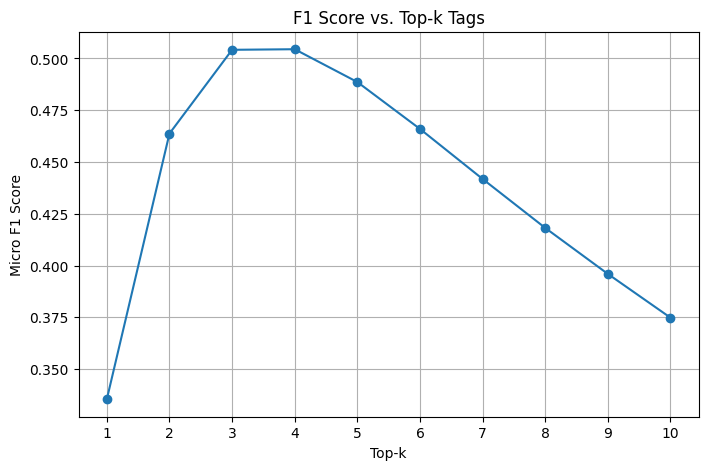

In [13]:
# 📘 Physics evaluation
avg, std, result_info = evaluate_multiple_seeds(
    df=df_full,
    sample_size=200000,
    k=5,
    seeds=[42],  # or multiple like [42, 43, 44]
    show_text=True
)

# ⛏️ Extract outputs from last pipeline run
df = result_info['df']
y_eval_valid = result_info['y_eval_valid']
y_pred_topk = result_info['y_pred_topk']
mlb_valid = result_info['mlb_valid']
idx_eval = result_info['idx_eval']
classifiers = result_info['classifiers']
valid_tag_indices = result_info['valid_tag_indices']
X_eval = result_info['X_eval']


# Generate probability matrix
probas = []
for idx in valid_tag_indices:
    clf = classifiers[idx]
    if clf is not None:
        probas.append(clf.predict_proba(X_eval)[:, 1])
    else:
        probas.append(np.zeros(X_eval.shape[0]))
probas = np.vstack(probas).T  # Shape: [n_samples, n_valid_tags]

# 📈 Plot F1-score as a function of K
ks, f1s = plot_f1_vs_k_only_model(y_eval_valid, probas, mlb_valid, max_k=10)


oracle_scores = evaluate_oracle_k(
    X_eval=result_info['X_eval'],
    y_eval=result_info['y_eval_valid'],
    classifiers=result_info['classifiers'],
    valid_tag_indices=result_info['valid_tag_indices'],
    mlb_valid=result_info['mlb_valid']
)

print("📊 Oracle-k Evaluation:")
for k, v in oracle_scores.items():
    print(f"{k.replace('_', ' ').title()}: {v:.4f}")


## Saving Model

In [14]:
import os
from joblib import dump
import json

# 1. 提取模型组件
model              = result_info['model']              # SentenceTransformer
classifiers        = result_info['classifiers']        # list of LogisticRegression
mlb                = result_info['mlb']                # MultiLabelBinarizer
mlb_valid          = result_info['mlb_valid']          # filtered MultiLabelBinarizer
valid_tag_indices  = result_info['valid_tag_indices']  # dict

# 2. 保存路径设置（Windows 本地路径）
ART_DIR = r'E:\Studium\Model'  # 注意 r 前缀避免转义字符问题
os.makedirs(ART_DIR, exist_ok=True)

# 3. 保存 SentenceTransformer 模型
model.save(os.path.join(ART_DIR, 'transformer'))

# 4. 保存其他对象
dump(classifiers, os.path.join(ART_DIR, 'classifiers.joblib'))
dump(mlb,         os.path.join(ART_DIR, 'mlb.joblib'))
dump(mlb_valid,   os.path.join(ART_DIR, 'mlb_valid.joblib'))

with open(os.path.join(ART_DIR, 'valid_tag_indices.json'), 'w') as fp:
    json.dump(valid_tag_indices, fp)

print("✅ 模型和参数已保存到：", ART_DIR)


✅ 模型和参数已保存到： E:\Studium\Model


In [15]:
from sentence_transformers import SentenceTransformer
from joblib import load
import json

ART_DIR = r'E:\Studium\Model'

model = SentenceTransformer(os.path.join(ART_DIR, 'transformer'))
classifiers = load(os.path.join(ART_DIR, 'classifiers.joblib'))
mlb = load(os.path.join(ART_DIR, 'mlb.joblib'))
mlb_valid = load(os.path.join(ART_DIR, 'mlb_valid.joblib'))
with open(os.path.join(ART_DIR, 'valid_tag_indices.json')) as fp:
    valid_tag_indices = json.load(fp)

print("✅ 已成功加载模型和参数")


✅ 已成功加载模型和参数


# Call the function and capture both top and bottom tag accuracy results
y_true = result_info['y_eval_valid']
y_pred = result_info['y_pred_topk']
mlb_valid = result_info['mlb_valid']

top, bottom = tag_wise_accuracy(y_true, y_pred, mlb_valid, top_n=10, min_support=50)
print("\n Top 10 Most Accurately Predicted Tags (when tag is present):")
for tag, acc, count in top:
    print(f"{tag:25} | Accuracy: {acc:.2%} | Support: {count}")

print("\n Bottom 10 Least Accurately Predicted Tags (when tag is present):")
for tag, acc, count in bottom:
    print(f"{tag:25} | Accuracy: {acc:.2%} | Support: {count}")

In [ ]:
top, bottom = tag_wise_accuracy(y_true, y_pred, mlb_valid, top_n=10, min_support=50)
print("\n Top 10 Most Accurately Predicted Tags (when tag is present):") for tag, acc, count in top: print(f"{tag:25} | Accuracy: {acc:.2%} | Support: {count}")

print("\n Bottom 10 Least Accurately Predicted Tags (when tag is present):") for tag, acc, count in bottom: print(f"{tag:25} | Accuracy: {acc:.2%} | Support: {count}")

In [ ]:
show_tag_examples("research-level", y_eval_valid, y_pred_topk, mlb_valid, df, idx_eval)



🕳️ Posts with tag: 'research-level' (max 5)
--------------------------------------------------------------------------------
❌ Missed by Model
Post ID: 188044
Post text:
 What are some important approximations, especially those that are state-of-the-art, used to approximate the many-body dynamics of atoms and molecules in the semiclassical regime? To be clear, I'm not really looking for semiclassical approximations for time-independent Hamiltonian systems. Are there any modern reference-level texts/monographs or review articles that develop the mathematical theory and its applications for said models?  ...
True Tags: ['quantum-mechanics', 'research-level', 'semiclassical']
Predicted Tags: ['approximations', 'condensed-matter', 'quantum-mechanics', 'resource-recommendations', 'statistical-mechanics']
✔️ Correct Match(s): {'quantum-mechanics'}
--------------------------------------------------------------------------------
❌ Missed by Model
Post ID: 45072
Post text:
 Quantum gauge theor

# Literature

In [ ]:
df_lit = load_and_clean_data("/content/drive/MyDrive/Data_Mining/Files/Literature/Literature_CSV_raw/posts_cleanbody.csv")


🔍 Evaluating for sample size = 500
📦 Loading and cleaning data...
📦 Using pre-loaded DataFrame...
🧠 Embedding texts...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

🔢 Binarizing tags...
✂️ Splitting data...
🔧 Training classifiers...


Training Tags: 100%|██████████| 528/528 [00:02<00:00, 242.45tag/s]


📊 Evaluating...

✅ Top-5 Tag Evaluation:
F1: 0.247
Hamming Loss: 0.011
Subset Accuracy: 0.000
Miss Rate: 0.340
Hit Rate: 0.660
❌ Completely Wrong Predictions: 34 out of 100
📉 Accuracy (at least 1 tag correct): 0.660
⚠️  Failure Rate (no tags correct):   0.340

📊 Average Metrics Across Seeds:
F1: 0.247 ± 0.000
Hamming Loss: 0.011 ± 0.000
Subset Accuracy: 0.000 ± 0.000
Miss Rate: 0.340 ± 0.000
Hit Rate: 0.660 ± 0.000

🔍 Evaluating for sample size = 1000
📦 Loading and cleaning data...
📦 Using pre-loaded DataFrame...
🧠 Embedding texts...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

🔢 Binarizing tags...
✂️ Splitting data...
🔧 Training classifiers...


Training Tags: 100%|██████████| 885/885 [00:05<00:00, 161.06tag/s]


📊 Evaluating...

✅ Top-5 Tag Evaluation:
F1: 0.250
Hamming Loss: 0.007
Subset Accuracy: 0.000
Miss Rate: 0.290
Hit Rate: 0.710
❌ Completely Wrong Predictions: 57 out of 200
📉 Accuracy (at least 1 tag correct): 0.710
⚠️  Failure Rate (no tags correct):   0.290

📊 Average Metrics Across Seeds:
F1: 0.250 ± 0.000
Hamming Loss: 0.007 ± 0.000
Subset Accuracy: 0.000 ± 0.000
Miss Rate: 0.290 ± 0.000
Hit Rate: 0.710 ± 0.000

🔍 Evaluating for sample size = 1500
📦 Loading and cleaning data...
📦 Using pre-loaded DataFrame...
🧠 Embedding texts...


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

🔢 Binarizing tags...
✂️ Splitting data...
🔧 Training classifiers...


Training Tags: 100%|██████████| 1120/1120 [07:48<00:00,  2.39tag/s]


📊 Evaluating...

✅ Top-5 Tag Evaluation:
F1: 0.274
Hamming Loss: 0.005
Subset Accuracy: 0.000
Miss Rate: 0.243
Hit Rate: 0.757
❌ Completely Wrong Predictions: 73 out of 300
📉 Accuracy (at least 1 tag correct): 0.757
⚠️  Failure Rate (no tags correct):   0.243

📊 Average Metrics Across Seeds:
F1: 0.274 ± 0.000
Hamming Loss: 0.005 ± 0.000
Subset Accuracy: 0.000 ± 0.000
Miss Rate: 0.243 ± 0.000
Hit Rate: 0.757 ± 0.000

🔍 Evaluating for sample size = 2000
📦 Loading and cleaning data...
📦 Using pre-loaded DataFrame...
🧠 Embedding texts...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

🔢 Binarizing tags...
✂️ Splitting data...
🔧 Training classifiers...


Training Tags: 100%|██████████| 1303/1303 [09:38<00:00,  2.25tag/s]


📊 Evaluating...

✅ Top-5 Tag Evaluation:
F1: 0.280
Hamming Loss: 0.005
Subset Accuracy: 0.000
Miss Rate: 0.247
Hit Rate: 0.752
❌ Completely Wrong Predictions: 99 out of 400
📉 Accuracy (at least 1 tag correct): 0.752
⚠️  Failure Rate (no tags correct):   0.247

📊 Average Metrics Across Seeds:
F1: 0.280 ± 0.000
Hamming Loss: 0.005 ± 0.000
Subset Accuracy: 0.000 ± 0.000
Miss Rate: 0.247 ± 0.000
Hit Rate: 0.752 ± 0.000

🔍 Evaluating for sample size = 4000
📦 Loading and cleaning data...
📦 Using pre-loaded DataFrame...
🧠 Embedding texts...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

🔢 Binarizing tags...
✂️ Splitting data...
🔧 Training classifiers...


Training Tags: 100%|██████████| 1912/1912 [14:53<00:00,  2.14tag/s]


📊 Evaluating...

✅ Top-5 Tag Evaluation:
F1: 0.306
Hamming Loss: 0.003
Subset Accuracy: 0.000
Miss Rate: 0.221
Hit Rate: 0.779
❌ Completely Wrong Predictions: 177 out of 800
📉 Accuracy (at least 1 tag correct): 0.779
⚠️  Failure Rate (no tags correct):   0.221

📊 Average Metrics Across Seeds:
F1: 0.306 ± 0.000
Hamming Loss: 0.003 ± 0.000
Subset Accuracy: 0.000 ± 0.000
Miss Rate: 0.221 ± 0.000
Hit Rate: 0.779 ± 0.000


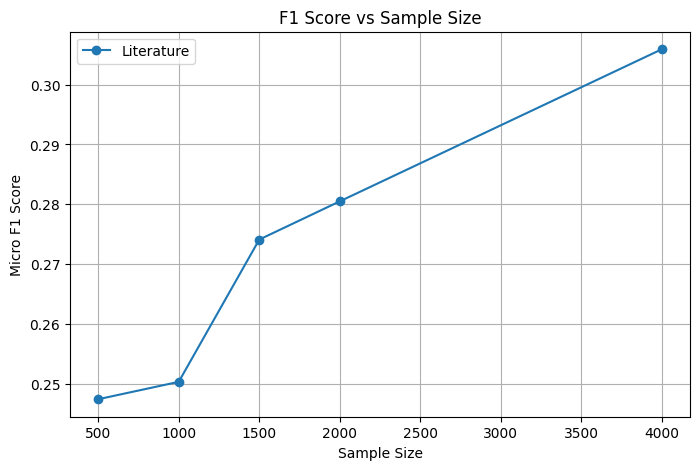

In [ ]:
# Example with df_lit, sample size vs f1
sample_sizes = 10000
sizes_lit, f1s_lit = evaluate_f1_vs_sample_size(df_lit, sample_sizes, seed=42, k=5)
plot_f1_vs_sample_size(sizes_lit, f1s_lit, label="Literature")

In [ ]:
# 🔍 Count how many posts contain each tag
count_jane = df_lit['Tags'].apply(lambda tags: 'jane-austen' in tags).sum()
count_lotr = df_lit['Tags'].apply(lambda tags: 'the-lord-of-the-rings' in tags).sum()

# 🖨️ Print results
print(f"📚 Number of posts tagged with 'jane-austen': {count_jane}")
print(f"🧙‍♂️ Number of posts tagged with 'the-lord-of-the-rings': {count_lotr}")

📚 Number of posts tagged with 'jane-austen': 55
🧙‍♂️ Number of posts tagged with 'the-lord-of-the-rings': 70


In [ ]:
print(len(df_lit))

6780


📦 Loading and cleaning data...
📦 Using pre-loaded DataFrame...
🧠 Embedding texts...


Batches:   0%|          | 0/106 [00:00<?, ?it/s]

🔢 Binarizing tags...
✂️ Splitting data...
🔧 Training classifiers...


Training Tags: 100%|██████████| 2571/2571 [20:41<00:00,  2.07tag/s]


📊 Evaluating...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



✅ Top-5 Tag Evaluation:
F1: 0.353
F1 Weighted Macro: 0.302
Hamming Loss: 0.002
Subset Accuracy: 0.000
Miss Rate: 0.173
Hit Rate: 0.827
Precision: 0.262
Recall: 0.538
❌ Completely Wrong Predictions: 235 out of 1356
📉 Accuracy (at least 1 tag correct): 0.827
⚠️  Failure Rate (no tags correct):   0.173

✅ Examples with at least one correct tag:

Post: I read this book probably in the 1999-2001 range, as a library book. The text was in English; this was in the state of Ohio in the US. I don't recall the particular copy having notable wear or fading like it had been around for a long time. The 'plot' involved a modern class of schoolkids having a f ...
True Tags: {'interactive-fiction', 'identification-request'}
Predicted Tags: {'historical-context', 'history-of-literature', 'identification-request', 'short-stories', 'inspiration'}
✔️ Correct Match(s): {'identification-request'}
--------------------------------------------------------------------------------
Post: The Chimney Sweeper from 

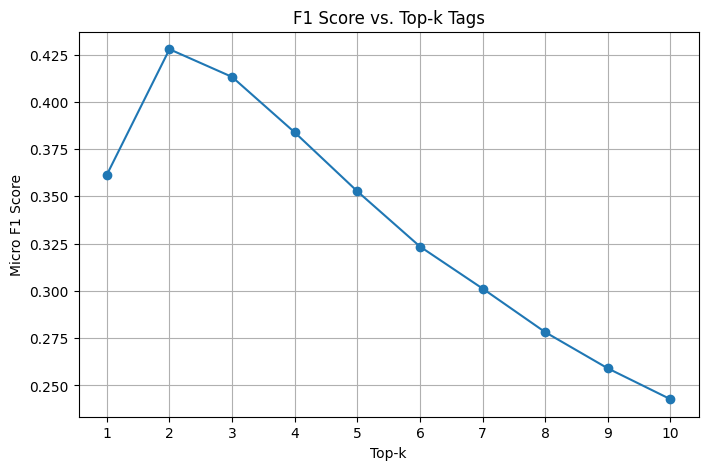


✅ Top 10 Most Accurately Predicted Tags:
f-scott-fitzgerald        | Accuracy: 100.00% | Support: 10
the-great-gatsby          | Accuracy: 100.00% | Support: 10
swimming-in-the-dark      | Accuracy: 100.00% | Support: 9
the-lord-of-the-rings     | Accuracy: 100.00% | Support: 9
tomasz-jedrowski          | Accuracy: 100.00% | Support: 9
chinese-language          | Accuracy: 100.00% | Support: 8
jane-austen               | Accuracy: 100.00% | Support: 8
physical-books            | Accuracy: 100.00% | Support: 8
macbeth                   | Accuracy: 100.00% | Support: 7
sherlock-holmes           | Accuracy: 100.00% | Support: 6

⚠️ Bottom 10 Least Accurately Predicted Tags:
allegory                  | Accuracy: 0.00% | Support: 5
animal-farm               | Accuracy: 0.00% | Support: 5
anna-karenina             | Accuracy: 0.00% | Support: 5
anton-chekhov             | Accuracy: 0.00% | Support: 5
cormac-mccarthy           | Accuracy: 0.00% | Support: 5
ferdowsi                  | Accura

In [ ]:
# 📘 Literature Evaluation

# Run evaluation pipeline
avg, std, result_info = evaluate_multiple_seeds(
    df=df_lit,
    sample_size=len(df_lit),  # Use full data
    k=5,
    seeds=[42],  # You can add more for stability
    show_text=True
)

# Extract evaluation results
df = result_info['df']
y_eval_valid = result_info['y_eval_valid']
y_pred_topk = result_info['y_pred_topk']
mlb_valid = result_info['mlb_valid']
idx_eval = result_info['idx_eval']
classifiers = result_info['classifiers']
valid_tag_indices = result_info['valid_tag_indices']
X_eval = result_info['X_eval']

# 🔢 Generate probability matrix
probas = []
for idx in valid_tag_indices:
    clf = classifiers[idx]
    if clf is not None:
        probas.append(clf.predict_proba(X_eval)[:, 1])
    else:
        probas.append(np.zeros(X_eval.shape[0]))
probas = np.vstack(probas).T  # Shape: [n_samples, n_valid_tags]

# 📈 Plot F1-score vs k
ks, f1s = plot_f1_vs_k_only_model(y_eval_valid, probas, mlb_valid, max_k=10)

# 📊 Tag-wise Accuracy Evaluation
top_tags, bottom_tags = tag_wise_accuracy(y_eval_valid, y_pred_topk, mlb_valid, top_n=10, min_support=5)

print("\n✅ Top 10 Most Accurately Predicted Tags:")
for tag, acc, count in top_tags:
    print(f"{tag:25} | Accuracy: {acc:.2%} | Support: {count}")

print("\n⚠️ Bottom 10 Least Accurately Predicted Tags:")
for tag, acc, count in bottom_tags:
    print(f"{tag:25} | Accuracy: {acc:.2%} | Support: {count}")


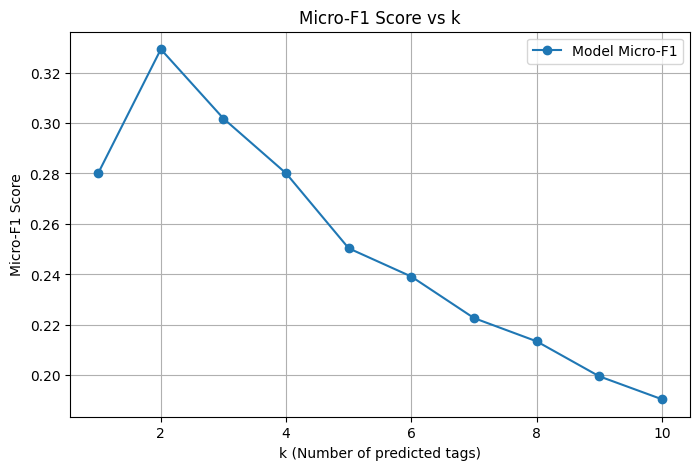

# Math

In [ ]:
df_mat = load_and_clean_data("/content/drive/MyDrive/Data_Mining/Files/Math/CSV/math_post_cleanbody.csv")

In [ ]:
#here!!
# Count all tag occurrences
tag_counts = df_mat['Tags'].explode().value_counts()

# Keep only tags used at least 50 times
common_tags = tag_counts[tag_counts >= 50].index.tolist()

# Filter posts to keep only common tags
df_mat['Tags'] = df_mat['Tags'].apply(lambda tags: [tag for tag in tags if tag in common_tags])
df_mat = df_mat[df_mat['Tags'].map(len) > 0].reset_index(drop=True)


In [ ]:
print(len(df_mat))

1641120


📦 Loading and cleaning data...
📦 Using pre-loaded DataFrame...
🧠 Embedding texts...


Batches:   0%|          | 0/6411 [00:00<?, ?it/s]

🔢 Binarizing tags...
✂️ Splitting data...
🔧 Training classifiers...


Training Tags: 100%|██████████| 1554/1554 [49:18<00:00,  1.90s/tag]


📊 Evaluating...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



✅ Top-5 Tag Evaluation:
F1: 0.398
F1 Weighted Macro: 0.369
Hamming Loss: 0.003
Subset Accuracy: 0.001
Miss Rate: 0.116
Hit Rate: 0.884
Precision: 0.295
Recall: 0.611
❌ Completely Wrong Predictions: 9488 out of 82056
📉 Accuracy (at least 1 tag correct): 0.884
⚠️  Failure Rate (no tags correct):   0.116

✅ Examples with at least one correct tag:

Post: I was asked the following problem: Given a coin with , what is the expected number of tosses until we receive two  in a row? I may use the fact that the expected number of tosses until the first  is . My solution: Let's denote . We want to find . At the same time, let's denote . From the given we kn ...
True Tags: {'expected-value', 'probability'}
Predicted Tags: {'expected-value', 'conditional-probability', 'statistics', 'probability', 'probability-theory'}
✔️ Correct Match(s): {'expected-value', 'probability'}
--------------------------------------------------------------------------------
Post: This a problem taken in one of the standa

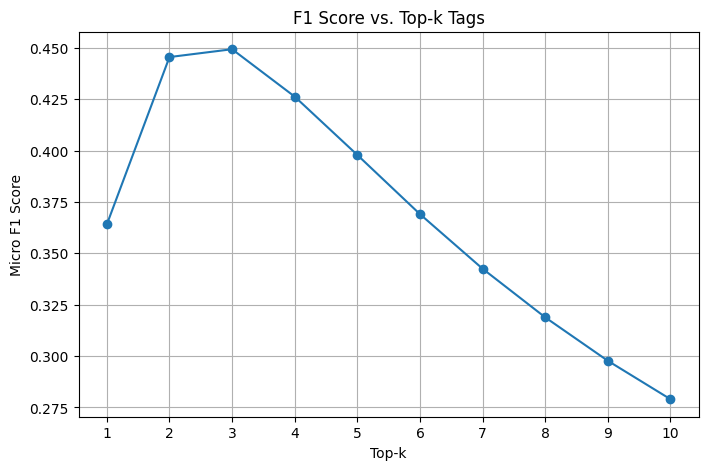


✅ Top 10 Most Accurately Predicted Tags:
probability               | Accuracy: 92.54% | Support: 5446
graph-theory              | Accuracy: 92.43% | Support: 1241
group-theory              | Accuracy: 90.98% | Support: 2538
category-theory           | Accuracy: 90.00% | Support: 740
abstract-algebra          | Accuracy: 88.39% | Support: 4213
linear-algebra            | Accuracy: 87.93% | Support: 6511
dice                      | Accuracy: 87.91% | Support: 91
matrices                  | Accuracy: 86.91% | Support: 2849
eigenvalues-eigenvectors  | Accuracy: 86.46% | Support: 694
general-topology          | Accuracy: 86.20% | Support: 2855

⚠️ Bottom 10 Least Accurately Predicted Tags:
chessboard                | Accuracy: 0.00% | Support: 20
constructive-mathematics  | Accuracy: 0.00% | Support: 20
convention                | Accuracy: 0.00% | Support: 20
error-propagation         | Accuracy: 0.00% | Support: 20
geometric-progressions    | Accuracy: 0.00% | Support: 20
gre-exam       

In [ ]:
# 📘 Mat Evaluation

# Run evaluation pipeline
avg, std, result_info = evaluate_multiple_seeds(
    df=df_mat,
    sample_size=int(len(df_mat)/4),  # Use full data
    k=5,
    seeds=[42],  # You can add more for stability
    show_text=True
)

# Extract evaluation results
df = result_info['df']
y_eval_valid = result_info['y_eval_valid']
y_pred_topk = result_info['y_pred_topk']
mlb_valid = result_info['mlb_valid']
idx_eval = result_info['idx_eval']
classifiers = result_info['classifiers']
valid_tag_indices = result_info['valid_tag_indices']
X_eval = result_info['X_eval']

# 🔢 Generate probability matrix
probas = []
for idx in valid_tag_indices:
    clf = classifiers[idx]
    if clf is not None:
        probas.append(clf.predict_proba(X_eval)[:, 1])
    else:
        probas.append(np.zeros(X_eval.shape[0]))
probas = np.vstack(probas).T  # Shape: [n_samples, n_valid_tags]

# 📈 Plot F1-score vs k
ks, f1s = plot_f1_vs_k_only_model(y_eval_valid, probas, mlb_valid, max_k=10)

# 📊 Tag-wise Accuracy Evaluation
top_tags, bottom_tags = tag_wise_accuracy(y_eval_valid, y_pred_topk, mlb_valid, top_n=10, min_support=20)

print("\n✅ Top 10 Most Accurately Predicted Tags:")
for tag, acc, count in top_tags:
    print(f"{tag:25} | Accuracy: {acc:.2%} | Support: {count}")

print("\n⚠️ Bottom 10 Least Accurately Predicted Tags:")
for tag, acc, count in bottom_tags:
    print(f"{tag:25} | Accuracy: {acc:.2%} | Support: {count}")

